In [18]:
import random
for i in iter(lambda : random.randint(0, 5), 2): # random.randint(0, 5)와 같이 0부터 5까지 무작위로 숫자를 생성할 때 2가 나오면 반복을 끝내도록 만들 수 있습니다. // 
    print(i, end=' ')

5 3 4 1 

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# 파이토치, 인공 신경망 모델의 재료들을 담고 있는 nn모듈, 최적화를 위한 optim 모듈, nn모듈의 함수 버전인 function F로 불러온다.
from torchvision import transforms, datasets, utils
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.is_available() 함수는 현재 컴퓨터에서 CUDA를 이용할 수 있는지 알아보는 함수이다. CUDA용 PyTorch를 설치하고 CUDA도 제대로 설치했다면, True를 반환, CUDA 설치하지않았거나 오류라면, False 반환!

이 반환된 값을 기준으로 CUDA를 지원하면 "CUDA"를 아니면, "CPU"를 torch.device에 설정한 후 변수에 저장해놓으면 여러 환경에서 돌아가야할 코드를 공유해야할 때 유용하다.

DEVICE 이 변수는 나중에 텐서와 가중치에 대한 연산을 CPU, GPU 중 어디에서 실행할지 결정할 때 쓰이는 변수입니다.

- 펭귄브로의 3분 딥러닝, 파이토치맛: PyTorch 코드로 맛보는 CNN, GAN, RNN, DQN ...
책 내용을 참고했습니다!

In [6]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

이미지가 수천,수만 개를 넘으므로 전체 데이터를 한번에 사용하는 것은 비효율적이므로, 여러 개의 배치 단위로 잘라서 사용한다.

epochs는 보통 많이 쓰이지만, 의미를 설명하자면 학습 데이터 전체를 총 몇 번을 걸쳐 볼 것인지를 설정하는 변수입니다!

In [7]:
EPOCHS     = 40
BATCH_SIZE = 64

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 이런 방식을 채택하지않고, 다음과 같은 방식을 통해서 train data & test data를 설정해주었다.

train, test 설정방법 : https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

CIFAR10 데이터셋을 사용합니다. CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻

In [20]:
transform_CIFAR10 = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 빼줌!
])
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root = './data_CIFAR10', train = True, 
        download  = True, transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        root  = './data_CIFAR10', train  = False,
        download = True, transform = transform_CIFAR10),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Files already downloaded and verified
Files already downloaded and verified


코딩 전에 생각해볼 것들!

- 입력 데이터 : image( C , H , W )
- 출력 데이터 : class number ( 10개의 class) 
- Optimizer: gradient descent method
- Loss function: cross entropy

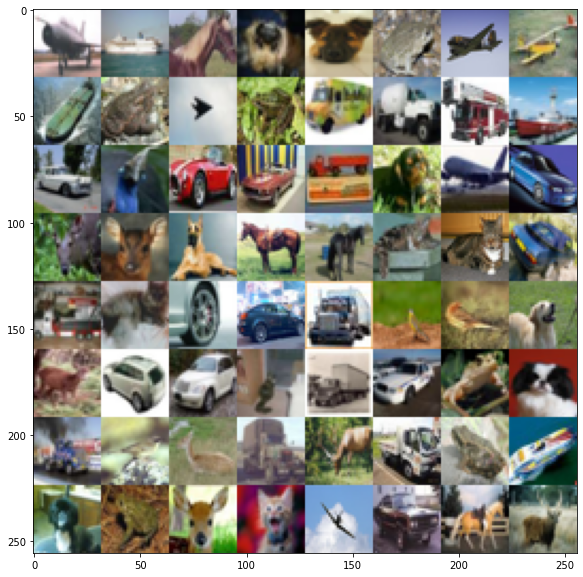

[['plane' ' ship' 'horse' '  dog' '  dog' ' frog' 'plane' 'plane']
 [' ship' ' frog' 'plane' ' frog' 'truck' 'truck' 'truck' ' ship']
 ['  car' ' bird' '  car' '  car' 'truck' '  dog' 'plane' '  car']
 [' deer' ' deer' '  dog' 'horse' 'horse' '  cat' '  cat' '  car']
 ['truck' '  cat' '  car' '  car' 'truck' ' bird' ' bird' '  dog']
 [' deer' '  car' '  car' '  cat' 'truck' '  car' ' frog' '  dog']
 ['truck' ' bird' ' deer' 'truck' ' deer' 'truck' ' frog' ' ship']
 ['  dog' ' frog' ' deer' '  cat' 'plane' '  car' 'horse' ' deer']]


In [21]:
# 파이썬 내장 함수 iter, next 사용 -> iter는 객체의 __iter__ 메서드를 호출해주고, next는 객체의 __next__ 메서드를 호출해줌.
# 반복할 값까지 다 나온 뒤에도 next(it, 10)을 호출하면 예외가 발생하지 않고 계속 10이 나옵니다.
dataiter = iter(train_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
# -> pytorch에서 nn를 사용하여 이미지를 훈련시킬 때 중간 결과가 어떻게 출력되는지 확인을 하고싶을때
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
classes = np.array(['plane', '  car', ' bird', '  cat', ' deer',
                    '  dog', ' frog', 'horse', ' ship', 'truck'])
print(classes[labels.reshape((8, 8))])

분류: ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’. 

# 합성곱 신경망(Convolution Neural Network) 정의하기

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3)
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(4056, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 4056)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x

# 손실 함수와 Optimizer 정의하기
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용

- 최적화(optimizer)는 각 학습 단계에서 모델의 오류를 줄이기 위해 모델 매개변수를 조정하는 과정

In [23]:
model     = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 30, 30]             224
            Conv2d-2           [-1, 16, 28, 28]           1,168
            Conv2d-3           [-1, 24, 26, 26]           3,480
         Dropout2d-4           [-1, 24, 26, 26]               0
            Linear-5                  [-1, 128]         519,296
            Linear-6                   [-1, 10]           1,290
Total params: 525,458
Trainable params: 525,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.40
Params size (MB): 2.00
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


# 신경망 학습하기

최적화 코드를 반복하여 수행하는 train와 테스트 데이터로 모델의 성능을 측정하는 evaluate를 정의

https://tutorials.pytorch.kr/beginner/basics/optimization_tutorial.html

In [24]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        output = model(data)
        loss = F.cross_entropy(output, target)
        
        # 역전파
        optimizer.zero_grad() # Gradient 매개변수를 0으로 만들기
        loss.backward()
        # loss.backwards()를 호출하여 예측 손실(prediction loss)을 역전파합니다. 
        # PyTorch는 각 매개변수에 대한 손실의 gradient를 저장
        optimizer.step()
        # 변화도를 계산한 뒤에는 optimizer.step()을 호출하여 역전파 단계에서 수집된 gradient로 매개변수를 조정!

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [25]:
def evaluate(model, test_loader):
    model.eval()
    # evaluation 과정에서 사용하지 않아야 하는 layer들을 알아서 off 시키도록 하는 함수
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [26]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300869
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.285779
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.259312
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.117934
[1] Test Loss: 1.9911, Accuracy: 29.55%
Train Epoch: 2 [0/50000 (0%)]	Loss: 2.024781
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.049820
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.936077
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.928017
[2] Test Loss: 1.9973, Accuracy: 28.84%
Train Epoch: 3 [0/50000 (0%)]	Loss: 2.098581
Train Epoch: 3 [12800/50000 (26%)]	Loss: 2.223846
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.045042
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.956430
[3] Test Loss: 1.7398, Accuracy: 39.30%
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.819778
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.855007
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.896183
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.729770
[4] Test Loss: 1.6768, Accuracy: 40.74%
Train Epoch: 5 [0/50000 (0%)]	Loss: 1.784763
Train Epoch: 5 

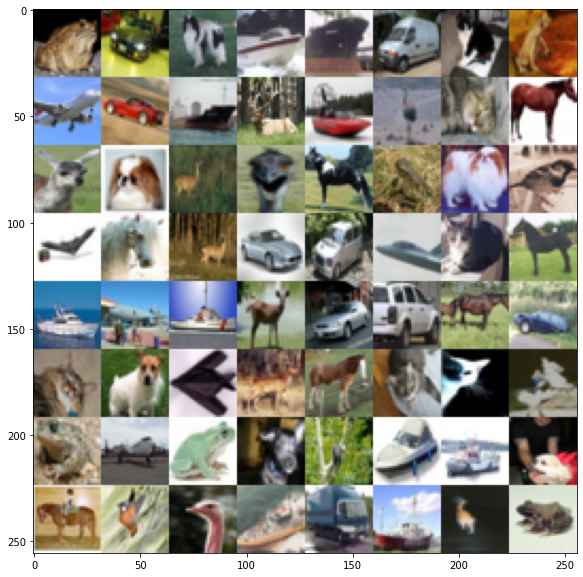

your predict : 
[[' frog' ' frog' '  dog' 'plane' ' deer' '  car' '  cat' ' frog']
 ['plane' '  car' ' ship' ' deer' ' ship' ' bird' ' frog' 'horse']
 [' bird' 'horse' ' frog' ' bird' 'horse' ' frog' '  dog' ' deer']
 ['plane' '  cat' ' deer' '  car' '  dog' 'plane' '  cat' 'horse']
 [' ship' 'plane' ' ship' ' deer' '  car' '  car' 'horse' '  car']
 ['  cat' '  dog' '  cat' ' deer' 'horse' '  cat' ' bird' '  cat']
 [' frog' 'plane' ' frog' '  cat' ' deer' '  car' '  car' '  cat']
 [' frog' ' deer' ' bird' ' ship' 'truck' ' ship' ' frog' ' frog']]

answer : 
[[' frog' '  car' '  dog' ' ship' ' ship' 'truck' '  cat' ' frog']
 ['plane' '  car' ' ship' ' deer' ' ship' ' bird' '  cat' 'horse']
 [' deer' '  dog' ' deer' ' bird' 'horse' ' frog' '  dog' ' bird']
 ['plane' 'horse' ' deer' '  car' '  car' 'plane' '  cat' 'horse']
 [' ship' 'plane' ' ship' ' deer' '  car' '  car' 'horse' '  car']
 ['  cat' '  dog' 'plane' ' deer' 'horse' '  cat' '  cat' 'horse']
 [' frog' 'plane' ' frog' '  dog' 

In [27]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

your_predict = model(images.to(DEVICE)).max(1)[1].view(8, 8).cpu()
answer = labels.reshape((8, 8))
correct = your_predict == answer

print("your predict : ")
print(classes[your_predict])
print("\nanswer : ")
print(classes[answer])
print("\ncorrectness :", correct.sum().item()/64)
print(correct)